In [10]:
%matplotlib notebook
import logging

from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
from matplotlib import cm
import scqubits as scq
from scipy.optimize import curve_fit
from quantum_builder import QuantumBuilder
import ipywidgets
import matplotlib.gridspec as gridspec
import os

plt.style.use('support-files/qubit.mplstyle')

FLUX = float
FLUX_NUMBER = int

cos = np.cos
sin = np.sin
pi = np.pi

fF = 10 ** (-15)
c = 10**(-10) #F/m Capacitance on interface
h = 6.64 * 10**(-34)
e = 1.6 * 10**(-19)
um = 10**(-6)
GHz = 10**(9)
kOhm = 10**3
Rq = 6.484*kOhm
Delta = 3.1*10**(-23) # Superconducting delta
Phi0 = h/(2 * e)
Gauss = 10**(-4) # Gauss to Wb/m²

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}
CMAPS =  ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('Reds')
COLORMAP_ENERGY = plt.get_cmap('viridis')
COLORMAP_STATE = plt.get_cmap('hsv')

R_square_room_temperature = {'Dynamic-20sccm': 6700.0, 'Static-0.4mBar': 17000, 'Static-0.25mBar': 12170.0, 'Static-0.1mBar': 5670.0, 'Static-0.13mBar': 8000}
RESISTANCE_COLD_SCALING = 1.1

def eval_expected_ej0(resistance_rt):
    EJ0 = Rq / (resistance_rt * RESISTANCE_COLD_SCALING) * Delta / 2
    return EJ0/h/GHz

def eval_resitance_from_ej0(x_side: float, y_side: float, EJ0: float):
    N_squares= x_side/100 * y_side/100
    EJ0 = EJ0 * h * GHz
    return Rq * N_squares * Delta / 2 / EJ0 / kOhm

def c_interdigitated(W: float, L: float, N: int):
    return c * N * (W + L)

def ec_interdigitated(W: float, L: float, N: int):
    C = c * N * (W + L)
    Ec = e**2 / (2 * C) / h / GHz
    return Ec

GHz = 10**9

#plt.style.use('support-files/qubit.mplstyle')

def to_dBm(array):
    # Conver to dBm. Values smaller than 0 are set to the lowest value in array
    min_value = 10 * np.log10(min(array[array > 0]))
    return 10 * np.nan_to_num(np.log10(array), nan = min_value, neginf=min_value)

def from_dBm(array):
    return np.power(10, array / 10)

def rabi_model(t, tDec, T, A, B, C, D, *args):
    """
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B) + C
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.exp(-t / tDec) + C*t + D

def rabi_model_beating(t, t_dec, T, A, B, C, D, E, t_beat):
    """
    OLD! Need to move t_beat to the end!
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B)sin(2π t / t_beat + E) + Ct + D
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.sin(2 * np.pi * t / t_beat + E) *  np.exp(-t / t_dec) + C*t + D

# Mfield

In [121]:
# Load 3d data
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_01_mfield-sweep.txt"
OFFSET = -0.278
# PERIOD = (-0.2794 - -0.5916)
PERIOD = (-0.27897 - -0.58793)

FILENAME_POINTS = "C:/ExperimentBlue/2021-08_photon-source/Ty_01_mfield-sweep_POINTS.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

# loaded
with open(FILENAME_POINTS) as fin:
    lines = (line for line in fin if not line.startswith('#'))
    experiment_data = np.loadtxt(lines)
experiment_x = (experiment_data[:, 0] - OFFSET) * MULTIPLIER
experiment_y = experiment_data[:, 1]

<IPython.core.display.Javascript object>


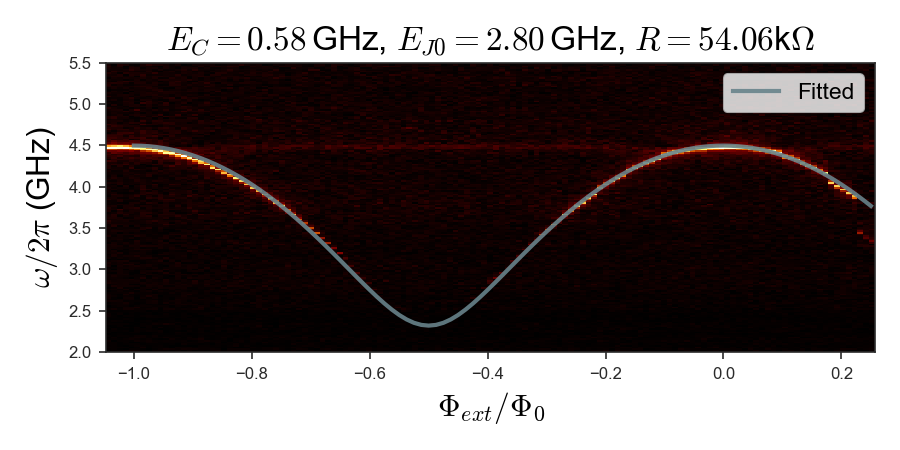

In [122]:
# Fitting Parameters
EC = 0.58
EJ0 = 2.8
FLUX_LIST = np.linspace(-1, 0.25, 101)

# Fitting
fitted = scq.TunableTransmon(
    EJmax=2*EJ0,
    EC=EC,
    d=0,       # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
fitted_01 = fitted.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=FLUX_LIST,
                                                  evals_count=2,
                                                  subtract_ground=True
                                                  ).energy_table[:, 1]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.afmhot)
fitted_plot, = ax.plot(FLUX_LIST, fitted_01,
        linestyle="-",
        color=MY_COLOURS["LightBlue"],
        label="Fitted",
        linewidth=2,
        alpha=0.9
        )

# experiment_plot, = ax.plot(experiment_x, experiment_y,
#         marker="o",
#         color=MY_COLOURS["DarkBlue"],
#         markeredgecolor="C2",
#         label="Raw",
#         markeredgewidth="0.4", markersize=4, alpha=0.95,
#         linestyle="")

ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)
ax.set_title(f"$E_C={EC:.2f}\,$GHz, $E_{{J0}}={EJ0:.2f}\,$GHz, $R={eval_resitance_from_ej0(JJ_side, JJ_side, EJ0):.2f}$k$\Omega$", fontsize=16)
ax.legend()
ax.set_ylim([2, 5.5])
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "pdf"))

In [123]:
CONTINUOUS_UPDATE = False
def update(EC, EJ0):
    
    ax.set_title(f"$E_C={EC:.2f}\,$GHz, $E_{{J0}}={EJ0:.2f}\,$GHz, $R={eval_resitance_from_ej0(JJ_side, JJ_side, EJ0):.2f}$k$\Omega$", fontsize=16)
    scq_energies = scq.TunableTransmon(
        EJmax=2*EJ0,
        EC=EC,
        d=0,       # no assymerty
        flux=0.0,  # defaults
        ng=0.0,
        ncut=21
        ).get_spectrum_vs_paramvals(param_name='flux',
                                                      param_vals=FLUX_LIST,
                                                      evals_count=2,
                                                      subtract_ground=True
                                                      ).energy_table
    fitted_plot.set_ydata(scq_energies[:, 1])
    
    ax.relim()
    ax.autoscale_view()
    
EC_widget = ipywidgets.FloatSlider(
    min=0.01, max=2, step=0.01,
    description="$E_{C}$ (GHz)", value=EC,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
EC_widget.style.handle_color = 'red'
EJ0_widget = ipywidgets.FloatSlider(
    min=1, max=100,
    description="$E_{J0}$ (GHz)", value=EJ0,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
EJ0_widget.style.handle_color = 'red'

offset_widget = ipywidgets.FloatSlider(
    min=-0.2, max=0.2, step=0.001,
    readout_format='.4f',
    description="offset", value=OFFSET,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
multiplier_widget = ipywidgets.FloatSlider(
    min=0.1, max=20, step=0.1,
    description="multiplier", value=MULTIPLIER,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Toggle Expected',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(5, 1)
ui[0, :] = EC_widget
ui[1, :] = EJ0_widget
# ui[2, :] = offset_widget
# ui[3, :] = multiplier_widget
# ui[4, :] = toggle_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EC": EC_widget,
        "EJ0": EJ0_widget,
#         "offset": offset_widget,
#         "multiplier": multiplier_widget,
#         "toggle_experiment": toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatSlider(value=0.58, continuous_update=False, description='$E_{C}$ (GHz)', layout=…

Output()

# Rabi oscillations at zero magnetic field bias

### Ty_04_rabi-freq-sweep_vna0dBm
4.52G on the side

### Ty_05_rabi-power-sweep
-2dBm to -10dBm are all good values to use

In [4]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_05_rabi-power-sweep.txt"
VARIABLE = "Power (dBm)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f".cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

Loaded cached parameters!


 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


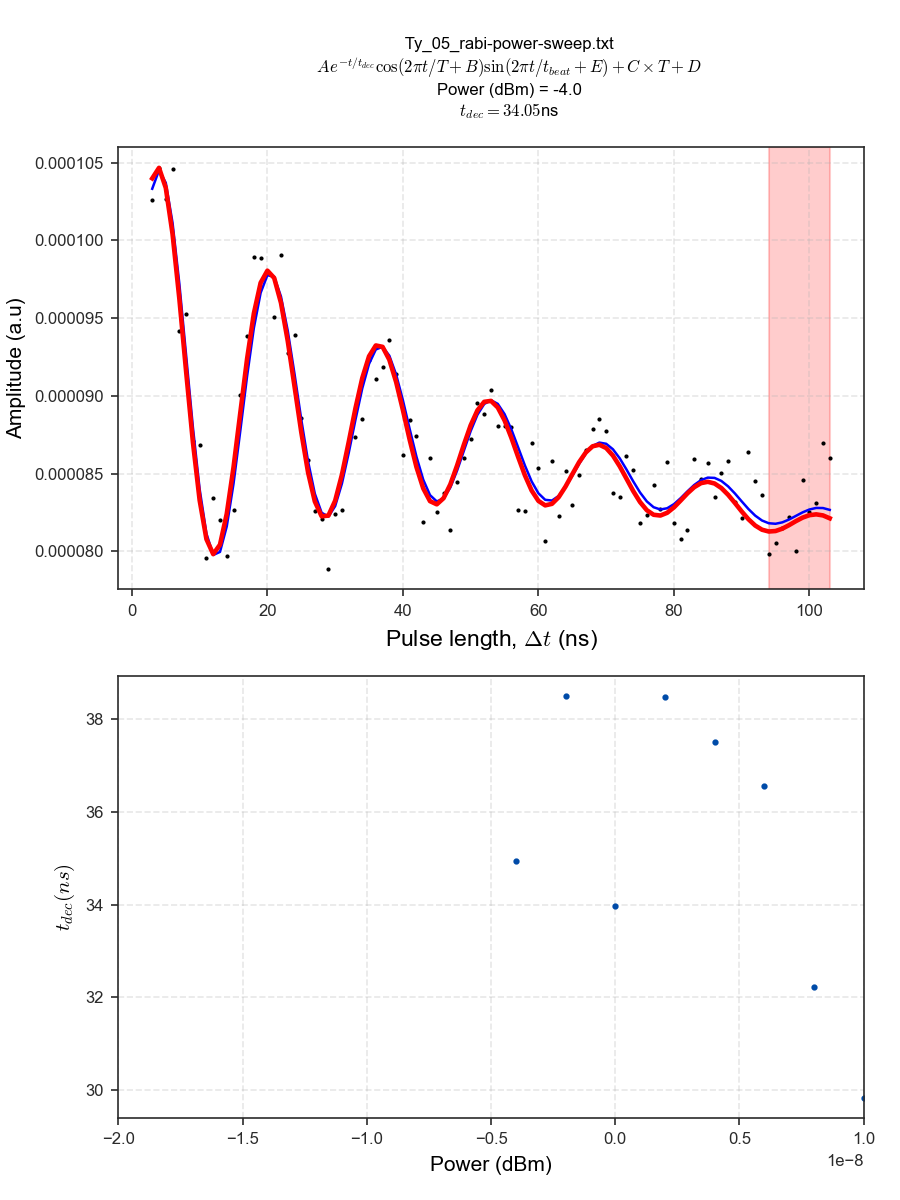

In [5]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f".cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [6]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

No parameters saved for this plot
No parameters saved for this plot
No parameters saved for this plot
No parameters saved for this plot
Loaded parameters!: [38.48620589250885, 13.443865995632919, 1.8162355206392128e-05, 0.2829904023016546, -8.663746473603325e-08, 6.178926615355544e-05, 1.5707963267948966, 8000.0]
Loaded parameters!: [33.97913519615134, 14.73668883073154, 1.818342752960619e-05, 0.15005182508502443, -8.918020485398482e-08, 7.357267001095485e-05, 1.5707963267948966, 8000.0]
Loaded parameters!: [38.495020267346504, 16.019163515291048, 1.708759024234712e-05, 0.2134495280981701, -1.0302032743071906e-07, 8.40353716451683e-05, 1.5707963267948966, 8000.0]
No parameters saved for this plot
No parameters saved for this plot
No parameters saved for this plot
Loaded parameters!: [34.94818625493924, 16.311941220293093, 1.5054796004352407e-05, -0.10687013845651437, -9.953429059249242e-08, 9.164453173024636e-05, 1.5707963267948966, 8000.0]
Loaded parameters!: [38.495020267346504, 16.0

Loaded parameters!: [36.55853018806263, 10.467844299214569, 2.1009703225802465e-05, 0.6498901297114905, -8.641707114296739e-08, 3.894598361702161e-05, 1.5707963267948966, 8000.0]
Stored parameters!{11: [38.48620589250885, 13.443865995632919, 1.8162355206392128e-05, 0.2829904023016546, -8.663746473603325e-08, 6.178926615355544e-05, 1.5707963267948966, 8000.0], 10: [33.97913519615134, 14.73668883073154, 1.818342752960619e-05, 0.15005182508502443, -8.918020485398482e-08, 7.357267001095485e-05, 1.5707963267948966, 8000.0], 9: [38.495020267346504, 16.019163515291048, 1.708759024234712e-05, 0.2134495280981701, -1.0302032743071906e-07, 8.40353716451683e-05, 1.5707963267948966, 8000.0], 8: [34.94818625493924, 16.311941220293093, 1.5054796004352407e-05, -0.10687013845651437, -9.953429059249242e-08, 9.164453173024636e-05, 1.5707963267948966, 8000.0], 12: [37.51236268772337, 12.069391063143197, 1.869872948682434e-05, 0.433686839466587, -8.552121501246111e-08, 5.0593722973599887e-05, 1.57079632679

Stored parameters!{11: [38.48620589250885, 13.443865995632919, 1.8162355206392128e-05, 0.2829904023016546, -8.663746473603325e-08, 6.178926615355544e-05, 1.5707963267948966, 8000.0], 10: [33.97913519615134, 14.73668883073154, 1.818342752960619e-05, 0.15005182508502443, -8.918020485398482e-08, 7.357267001095485e-05, 1.5707963267948966, 8000.0], 9: [38.495020267346504, 16.019163515291048, 1.708759024234712e-05, 0.2134495280981701, -1.0302032743071906e-07, 8.40353716451683e-05, 1.5707963267948966, 8000.0], 8: [34.94818625493924, 16.311941220293093, 1.5054796004352407e-05, -0.10687013845651437, -9.953429059249242e-08, 9.164453173024636e-05, 1.5707963267948966, 8000.0], 12: [37.51236268772337, 12.069391063143197, 1.869872948682434e-05, 0.433686839466587, -8.552121501246111e-08, 5.0593722973599887e-05, 1.5707963267948966, 8000.0], 13: [36.55853018806263, 10.467844299214569, 2.1009703225802465e-05, 0.6498901297114905, -8.641707114296739e-08, 3.894598361702161e-05, 1.5707963267948966, 8000.0],

<IPython.core.display.Javascript object>


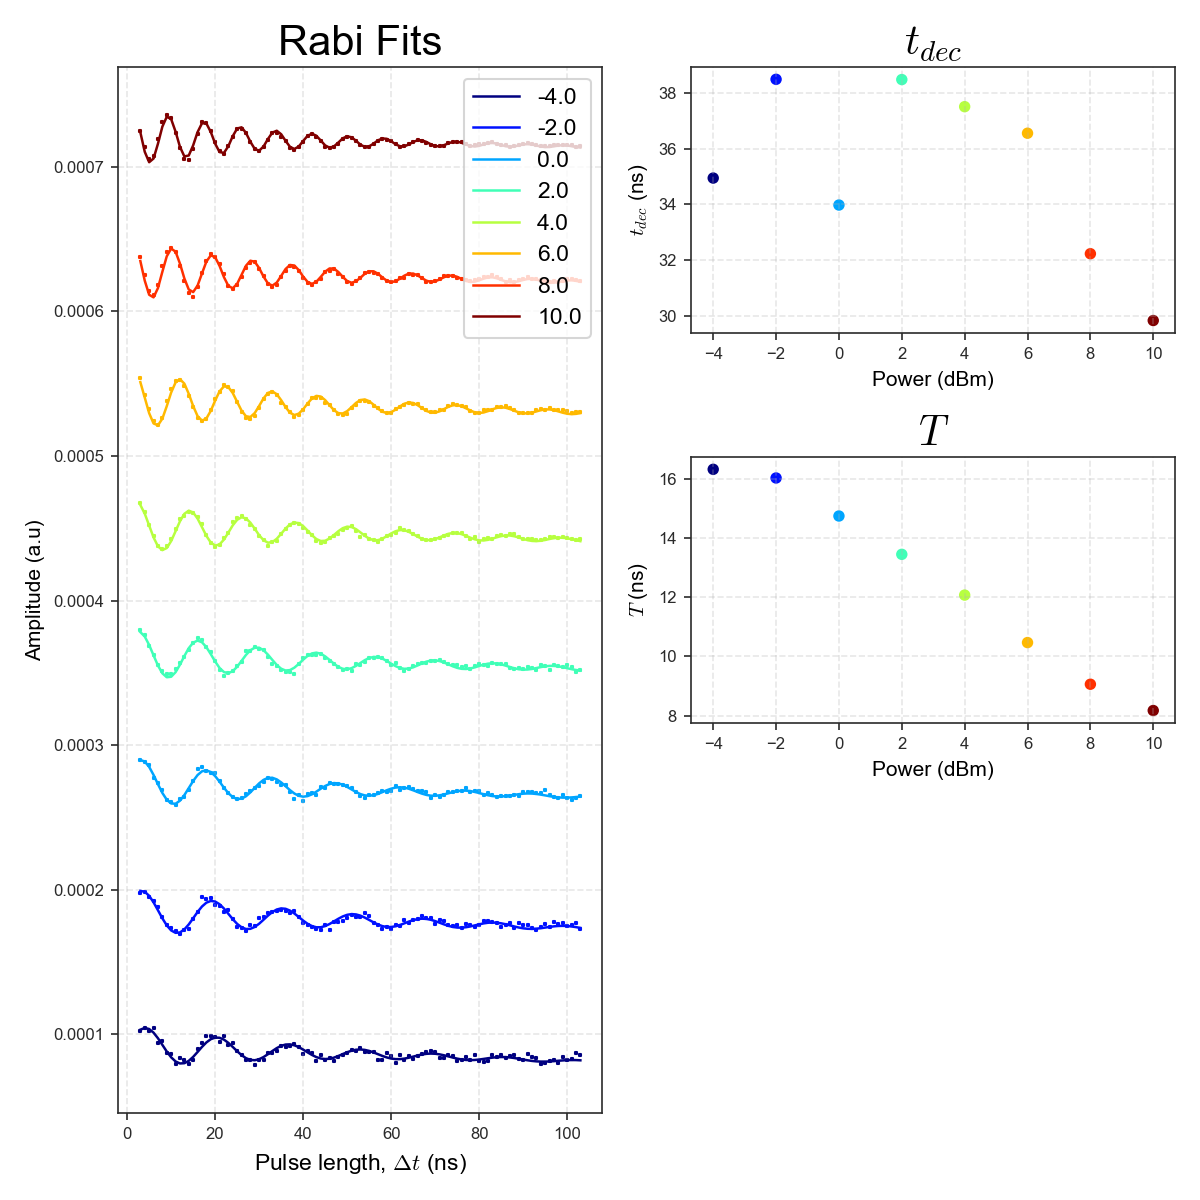

In [7]:
# Summarise the fittings:
SPACING = 0.0001
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-08_photon-source/Ay_16_rabi-freq-sweep_vna-5dBm_transmission.txt"
    
# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

# Plot transmission
# ax3 = plt.subplot(gs[2, 1])
# ax3.set_title("Transmission Spectrum")
# ax3.set_xlabel(VARIABLE, fontsize=10)
# ax3.set_ylabel("|t|", fontsize=10)


# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
# ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

### Ty_06_rabi-keysight-sweep
Use Keysight Frequnecy of more than 2MHz

In [29]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_06_rabi-keysight-sweep.txt"
VARIABLE = "Keysight Frequency (MHz)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    s
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f".cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


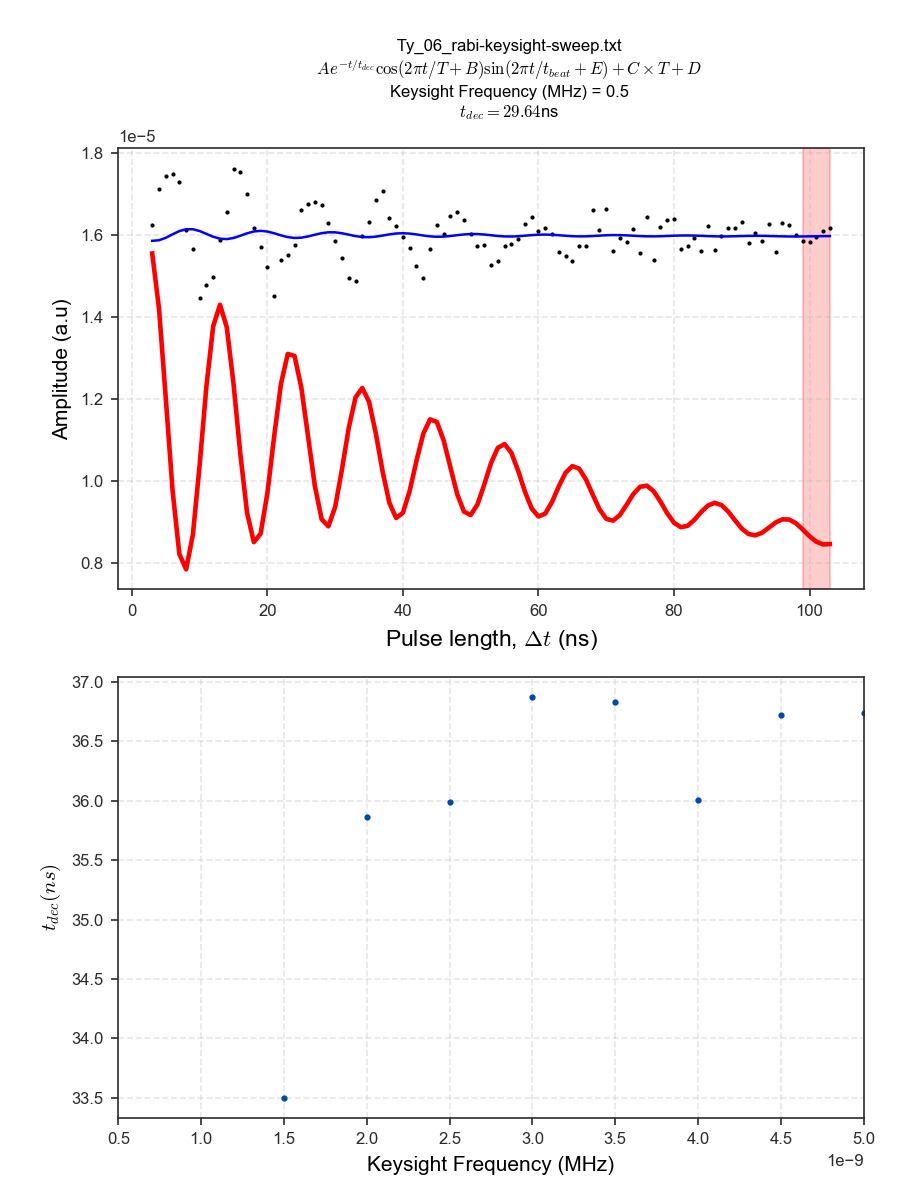

In [30]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f".cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [31]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Stored parameters!{5: [-68.05225654740914, 95.64794390369163, 4.851031259960374e-08, 7.724654193889615, -6.116769317354104e-08, 2.564045920089094e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [-68.05225654740914, 95.64794390369163, 4.851031259960374e-08, 7.724654193889615, -6.116769317354104e-08, 2.564045920089094e-05, 1.5707963267948966, 8000.0]
Stored parameters!{5: [48.839701519948164, 19.301172854690346, -3.702038169701745e-06, 6.954339499423192, -6.806750623679271e-08, 2.6093026134956936e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [48.839701519948164, 19.301172854690346, -3.702038169701745e-06, 6.954339499423192, -6.806750623679271e-08, 2.6093026134956936e-05, 1.5707963267948966, 8000.0]
Stored parameters!{5: [48.839701519948164, 10.0, 1.1702038169701745e-05, 6.283185307179586, -6.806750623679271e-08, 2.6093026134956936e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [48.839701519948164, 10.0, 1.1702038169701745e-05, 6.283185307179586, -6.806750623679271e-0

Loaded parameters!: [35.97489018518542, 10.489598604307352, 1.0655514073878007e-05, 6.827024514683612, -5.8520042358052e-08, 1.9904921399931374e-05, 1.5707963267948966, 8000.0]
Stored parameters!{5: [48.839701519948164, 10.0, 1.1702038169701745e-05, 6.283185307179586, -6.806750623679271e-08, 2.6093026134956936e-05, 1.5707963267948966, 8000.0], 4: [36.00101073046671, 10.48968257282652, 1.0656095115086664e-05, 6.827029539636155, -5.8519664054449147e-08, 1.9904894320041946e-05, 1.5707963267948966, 8000.0]}
Stored parameters!{5: [48.839701519948164, 10.0, 1.1702038169701745e-05, 6.283185307179586, -6.806750623679271e-08, 2.6093026134956936e-05, 1.5707963267948966, 8000.0], 4: [36.00101106690177, 10.489682570192995, 1.0656094827698615e-05, 0.5438442309518866, -5.851966440300441e-08, 1.990489433406489e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [36.00101106690177, 10.489682570192995, 1.0656094827698615e-05, 0.5438442309518866, -5.851966440300441e-08, 1.990489433406489e-05, 1.570796

Loaded parameters!: [36.83635494220769, 10.461482997937138, 1.7805143191780088e-05, 0.607053702983793, -7.385465607021106e-08, 3.214086689128642e-05, 1.5707963267948966, 8000.0]
Stored parameters!{5: [36.875990023610385, 10.482311177890791, 1.4747909109988893e-05, 0.5893120583831056, -6.759678051436683e-08, 2.604760336428744e-05, 1.5707963267948966, 8000.0], 4: [35.99145617930397, 10.489831426299164, 1.2130069810941125e-05, 0.4981046456694417, -5.851986385463091e-08, 1.9904910465380823e-05, 1.5707963267948966, 8000.0], 6: [36.83635494220769, 10.461482997937138, 1.7805143191780088e-05, 0.607053702983793, -7.385465607021106e-08, 3.214086689128642e-05, 1.5707963267948966, 8000.0], 7: [36.03248071881011, 10.473009921448662, 2.0882351189128885e-05, 0.6543210607346007, -8.725722906483063e-08, 3.897355451421286e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [36.03248071881011, 10.473009921448662, 2.0882351189128885e-05, 0.6543210607346007, -8.725722906483063e-08, 3.897355451421286e-05,

Loaded parameters!: [36.74290856403153, 10.46828339021076, 2.5627424126783973e-05, 0.7128237750373625, -1.0223317490874598e-07, 5.202971894314651e-05, 1.5707963267948966, 8000.0]
Stored parameters!{5: [36.875990023610385, 10.482311177890791, 1.4747909109988893e-05, 0.5893120583831056, -6.759678051436683e-08, 2.604760336428744e-05, 1.5707963267948966, 8000.0], 4: [35.99145617930397, 10.489831426299164, 1.2130069810941125e-05, 0.4981046456694417, -5.851986385463091e-08, 1.9904910465380823e-05, 1.5707963267948966, 8000.0], 6: [36.83635494220769, 10.461482997937138, 1.7805143191780088e-05, 0.607053702983793, -7.385465607021106e-08, 3.214086689128642e-05, 1.5707963267948966, 8000.0], 7: [36.006317800366254, 10.473040831059976, 2.0891971776408048e-05, 0.6543765189587231, -8.725975043303552e-08, 3.897378445865302e-05, 1.5707963267948966, 8000.0], 8: [36.727377432063236, 10.484317848843501, 2.3319407579872147e-05, 0.6797011859689917, -9.46501301780625e-08, 4.534536521187872e-05, 1.570796326794

Loaded parameters!: [35.87547642408137, 10.480234912541075, 8.331646898389697e-06, 0.2941913750884064, -4.973877383799266e-08, 1.4873389262559282e-05, 1.5707963267948966, 8000.0]
Stored parameters!{5: [36.875990023610385, 10.482311177890791, 1.4747909109988893e-05, 0.5893120583831056, -6.759678051436683e-08, 2.604760336428744e-05, 1.5707963267948966, 8000.0], 4: [35.99145631545531, 10.48983142414678, 1.2130069785895554e-05, 0.49810464142276967, -5.851986379402928e-08, 1.9904910461307357e-05, 1.5707963267948966, 8000.0], 6: [36.83635494220769, 10.461482997937138, 1.7805143191780088e-05, 0.607053702983793, -7.385465607021106e-08, 3.214086689128642e-05, 1.5707963267948966, 8000.0], 7: [36.006317800366254, 10.473040831059976, 2.0891971776408048e-05, 0.6543765189587231, -8.725975043303552e-08, 3.897378445865302e-05, 1.5707963267948966, 8000.0], 8: [36.727377432063236, 10.484317848843501, 2.3319407579872147e-05, 0.6797011859689917, -9.46501301780625e-08, 4.534536521187872e-05, 1.570796326794

Loaded parameters!: [33.53469528858607, 10.470519299770247, 4.510903577910245e-06, -0.29722558954012995, -2.8907364592787444e-08, 1.1620718693437738e-05, 1.5707963267948966, 8000.0]
Stored parameters!{5: [36.875990023610385, 10.482311177890791, 1.4747909109988893e-05, 0.5893120583831056, -6.759678051436683e-08, 2.604760336428744e-05, 1.5707963267948966, 8000.0], 4: [35.99145631545531, 10.48983142414678, 1.2130069785895554e-05, 0.49810464142276967, -5.851986379402928e-08, 1.9904910461307357e-05, 1.5707963267948966, 8000.0], 6: [36.83635494220769, 10.461482997937138, 1.7805143191780088e-05, 0.607053702983793, -7.385465607021106e-08, 3.214086689128642e-05, 1.5707963267948966, 8000.0], 7: [36.006317800366254, 10.473040831059976, 2.0891971776408048e-05, 0.6543765189587231, -8.725975043303552e-08, 3.897378445865302e-05, 1.5707963267948966, 8000.0], 8: [36.727377432063236, 10.484317848843501, 2.3319407579872147e-05, 0.6797011859689917, -9.46501301780625e-08, 4.534536521187872e-05, 1.570796326

<IPython.core.display.Javascript object>


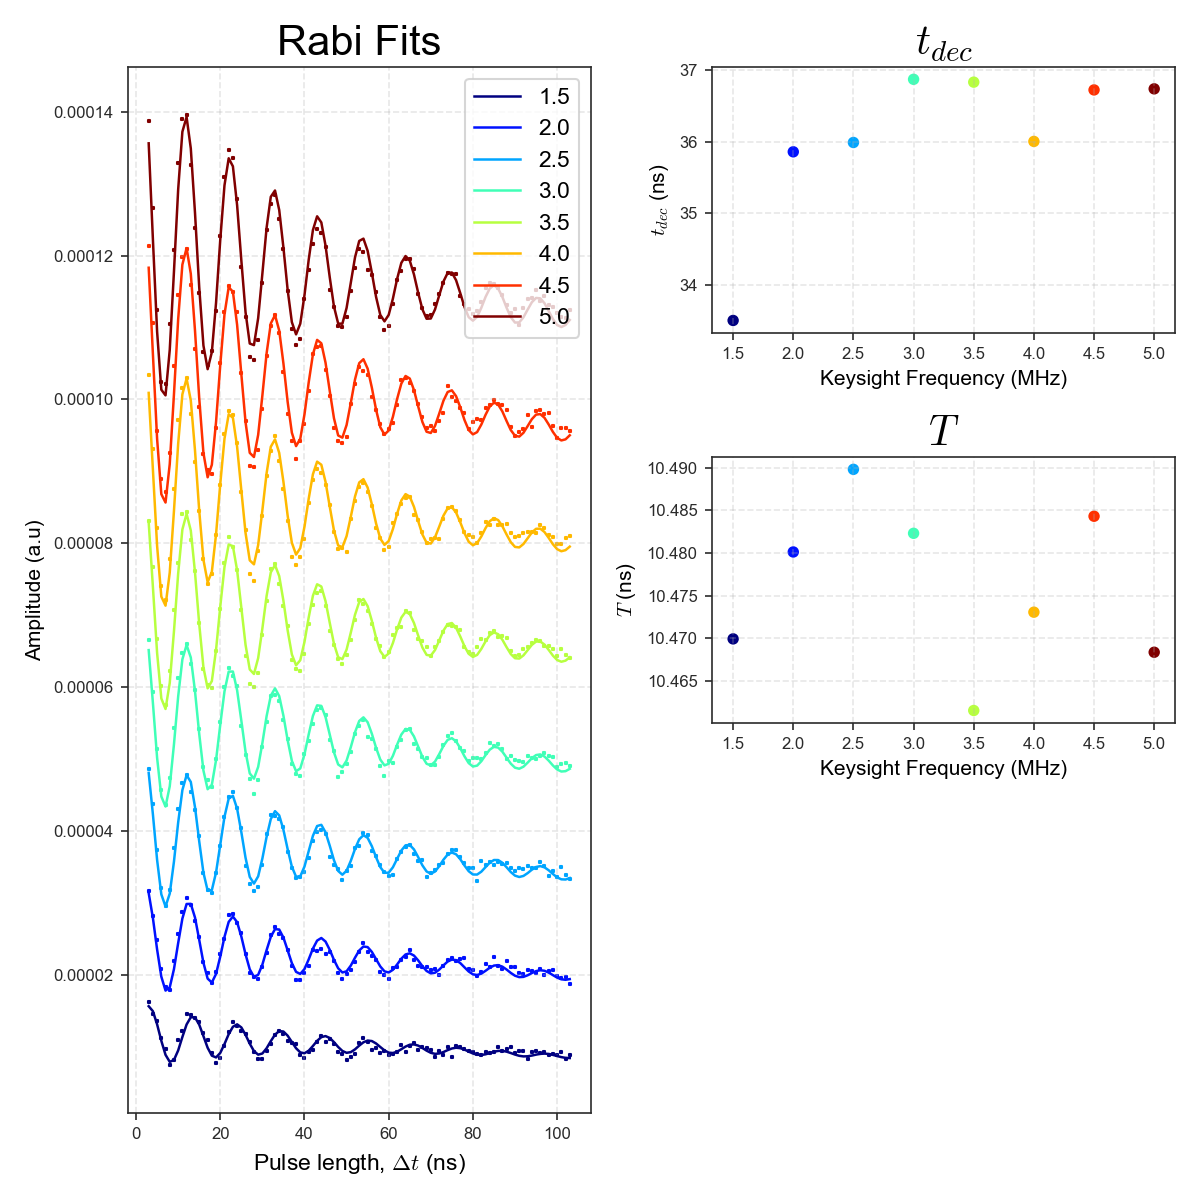

In [32]:
# Summarise the fittings:
SPACING = 0.00001
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-08_photon-source/Ay_16_rabi-freq-sweep_vna-5dBm_transmission.txt"

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

# Plot transmission
# ax3 = plt.subplot(gs[2, 1])
# ax3.set_title("Transmission Spectrum")
# ax3.set_xlabel(VARIABLE, fontsize=10)
# ax3.set_ylabel("|t|", fontsize=10)


# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
# ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

# Finding state for SPA measurements

## On resonance -5dBm

In [168]:
# Initial parameters
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_38_rabi-at-select-powers-for-spa-and-digitiser_-5dBm-6.905503G.txt"
with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
T_DATA = data[:,0]
y_data = data[:,1]

RABI_MODEL=rabi_model

<IPython.core.display.Javascript object>


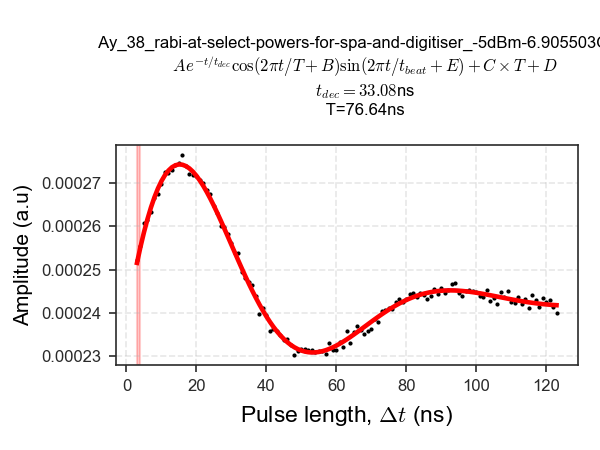

In [173]:
# Initial Guess
cut = (0, 1)
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
raw, = ax.plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax.plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax.plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax.axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax.set_ylabel("Amplitude (a.u)", fontsize=10)
ax.set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    $t_{{dec}} = {popt[0]:.2f}$
    T={popt[1]:.2f}ns
    """, fontsize=8)

plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, 
           A, B, C, D, E, 
           cut, user_toggle, fit_toggle):
    C = C / 10**6
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax.set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        $t_{{dec}} = {popt[0]:.2f}$ns
        T={popt[1]:.2f}ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax.patches = []
    ax.axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax.relim()
    ax.autoscale_view()
    return popt

def load_fit(_):
    fit_data = update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value,
        A_widget.value, B_widget.value, C_widget.value, D_widget.value, E_widget.value, 
        CUT_widget.value, user_toggle_widget.value,  fit_toggle_widget.value)
    
    t_dec_widget.value = fit_data[0]
    T_widget.value = fit_data[1]
    A_widget.value = fit_data[2]
    B_widget.value = fit_data[3]
    C_widget.value = fit_data[4] * 10**6
    D_widget.value = fit_data[5]
    E_widget.value = fit_data[6]
    t_beat_widget.value = fit_data[7] 


    print(f"Stored parameters!{fit_data}")

In [174]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_fit)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[8, 0] = user_toggle_widget
ui[8, 2] = fit_toggle_widget
ui[9, :] = load_parameters_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Stored parameters![ 1.07040014e+01  7.18880309e+01  4.61906795e-05  8.38348354e+00
 -9.41276304e-08  2.50082422e-04  1.57079633e+00  8.00000000e+03]
Stored parameters![ 3.11279816e+01 -7.69416450e+01 -5.88994227e-05  6.31786187e+00
  2.10658663e-08  2.40018813e-04  1.57079633e+00  8.00000000e+03]
Stored parameters![3.25767849e+01 7.66318334e+01 5.75760518e-05 6.25339530e+00
 1.86118316e-08 2.40231924e-04 1.57079633e+00 8.00000000e+03]


## On 6.915GHz -2dBm

In [175]:
# Initial parameters
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_38_rabi-at-select-powers-for-spa-and-digitiser_-2dBm-6.915G.txt"
with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
T_DATA = data[:,0]
y_data = data[:,1]

RABI_MODEL=rabi_model

 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


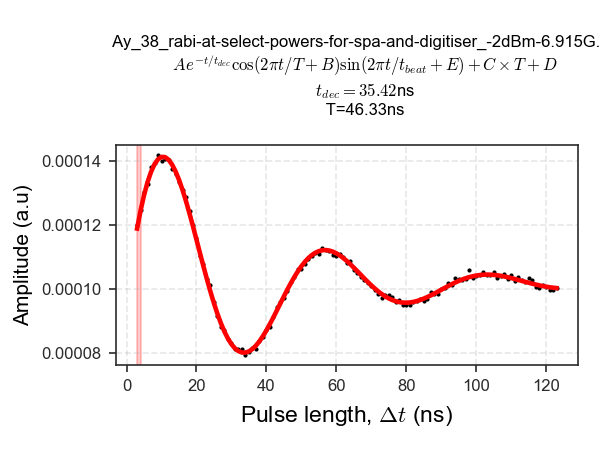

In [176]:
# Initial Guess
cut = (0, 1)
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
raw, = ax.plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax.plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax.plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax.axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax.set_ylabel("Amplitude (a.u)", fontsize=10)
ax.set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    $t_{{dec}} = {popt[0]:.2f}$
    T={popt[1]:.2f}ns
    """, fontsize=8)

plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, 
           A, B, C, D, E, 
           cut, user_toggle, fit_toggle):
    C = C / 10**6
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax.set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        $t_{{dec}} = {popt[0]:.2f}$ns
        T={popt[1]:.2f}ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax.patches = []
    ax.axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax.relim()
    ax.autoscale_view()
    return popt

def load_fit(_):
    fit_data = update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value,
        A_widget.value, B_widget.value, C_widget.value, D_widget.value, E_widget.value, 
        CUT_widget.value, user_toggle_widget.value,  fit_toggle_widget.value)
    
    t_dec_widget.value = fit_data[0]
    T_widget.value = fit_data[1]
    A_widget.value = fit_data[2]
    B_widget.value = fit_data[3]
    C_widget.value = fit_data[4] * 10**6
    D_widget.value = fit_data[5]
    E_widget.value = fit_data[6]
    t_beat_widget.value = fit_data[7] 


    print(f"Stored parameters!{fit_data}")

In [177]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_fit)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[8, 0] = user_toggle_widget
ui[8, 2] = fit_toggle_widget
ui[9, :] = load_parameters_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Stored parameters![ 7.80673154e+01  5.00651653e+01 -1.63174987e-05  3.53756615e+00
 -7.49244333e-08  1.06167682e-04  1.57079633e+00  8.00000000e+03]
Stored parameters![ 3.54233426e+01  4.63269372e+01 -5.52490718e-05  3.09636174e+00
  6.37578676e-09  1.00825047e-04  1.57079633e+00  8.00000000e+03]
Stored parameters![ 3.54166248e+01  4.63284712e+01 -5.52699692e-05  3.09615078e+00
  6.44479257e-09  1.00820436e-04  1.57079633e+00  8.00000000e+03]


# Incoherent spectrum

## Ty_10_-2dBm_4.48GHz_25MHz

In [168]:
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_10_-2dBm_4.48GHz_25MHz.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


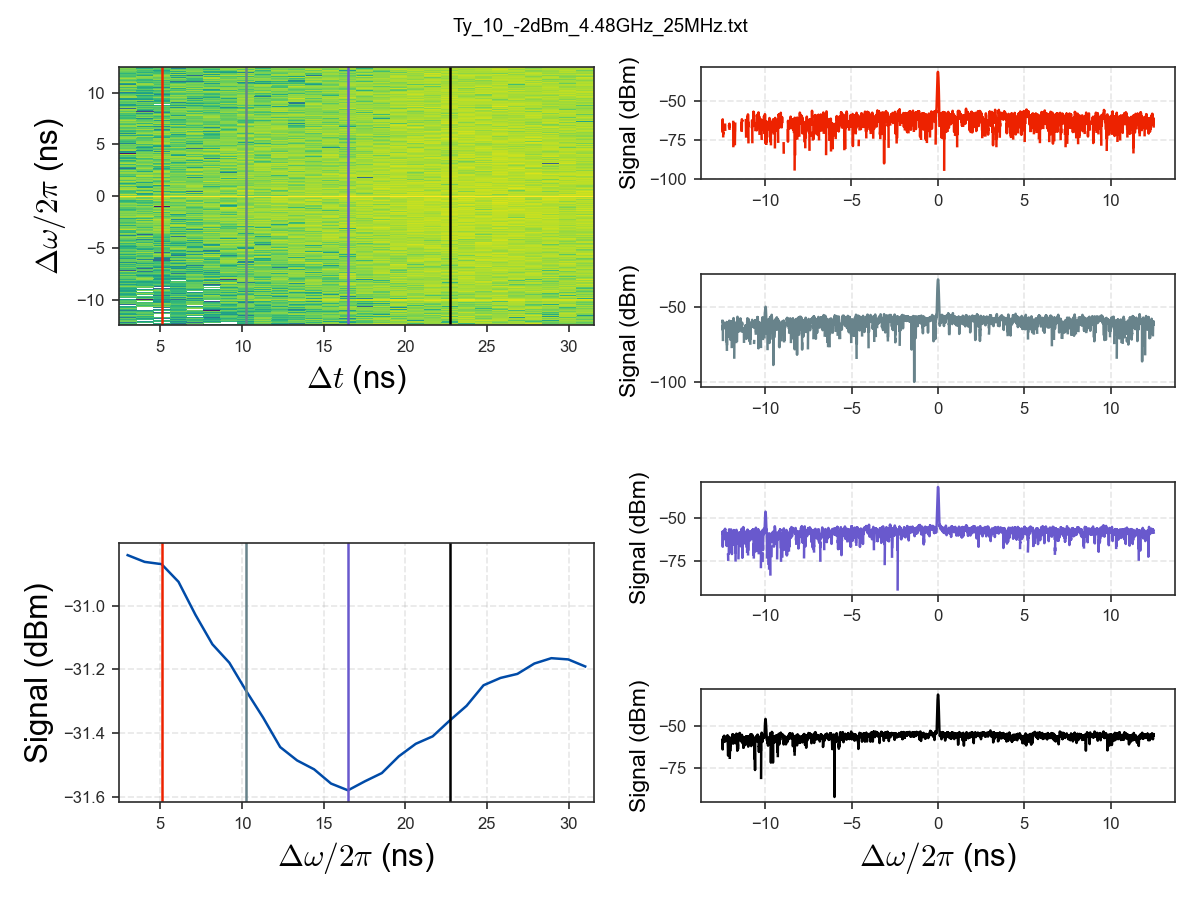

In [169]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

# Indexes where to slice
idx_list = [
    (2, MY_COLOURS["DarkRed"]),
    (7, MY_COLOURS["LightBlue"]),
    (13, MY_COLOURS["Purple"]),
    (19, "black")    
]

ax = plt.subplot(221)
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.viridis,
              vmax=-50
             )
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)

ax = plt.subplot(223, sharex=ax)
ax.plot(data3d_x, data3d_z[len(data3d_y) // 2])
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("Signal (dBm)", fontsize=15)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)

l = len(idx_list)
subplot_index = l*100 + 22 # Index magic :D
for i, (idx, col) in enumerate(idx_list):
    ax = plt.subplot(subplot_index + 2*i)
    ax.plot(data3d_y, 
            data3d_z[:,idx], 
             color=col,
#             label=f"@ {data3d_x[idx]:.2f}ns",
#             alpha=0.8+(i/l)*0.2, linewidth=l-i
           )
    ax.set_ylabel("Signal (dBm)", fontsize=11)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "pdf"), dpi=100)

## Ty_10_-2dBm_4.48GHz_25MHz_stacked-amplifers

In [179]:
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_10_-2dBm_4.48GHz_25MHz_stacked-amplifers.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


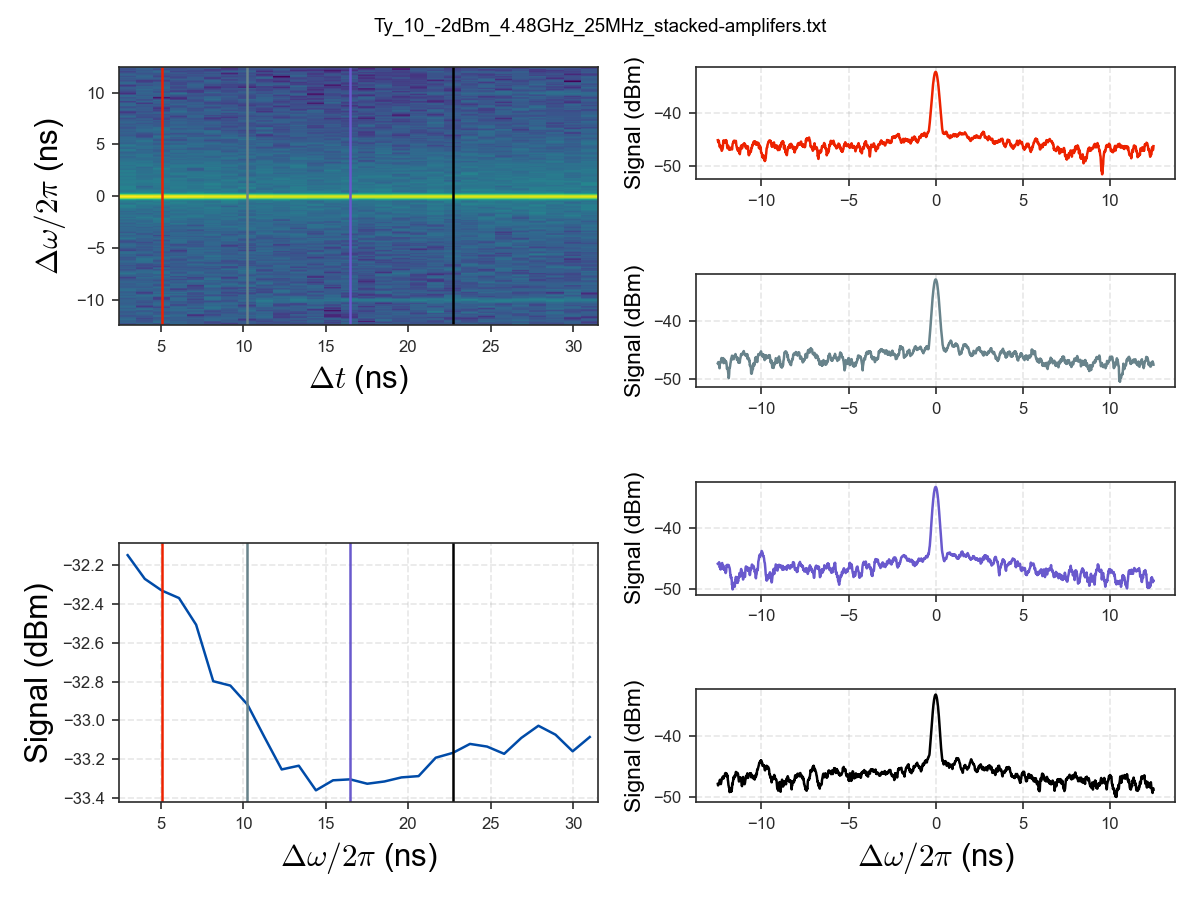

In [180]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

# Indexes where to slice
idx_list = [
    (2, MY_COLOURS["DarkRed"]),
    (7, MY_COLOURS["LightBlue"]),
    (13, MY_COLOURS["Purple"]),
    (19, "black")    
]

ax = plt.subplot(221)
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.viridis,
#               vmax=4.75*10**(-7)
             )
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)

ax = plt.subplot(223, sharex=ax)
ax.plot(data3d_x, data3d_z[len(data3d_y) // 2])
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("Signal (dBm)", fontsize=15)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)

l = len(idx_list)
subplot_index = l*100 + 22 # Index magic :D
for i, (idx, col) in enumerate(idx_list):
    ax = plt.subplot(subplot_index + 2*i)
    ax.plot(data3d_y, 
            data3d_z[:,idx], 
             color=col,
#             label=f"@ {data3d_x[idx]:.2f}ns",
#             alpha=0.8+(i/l)*0.2, linewidth=l-i
           )
    ax.set_ylabel("Signal (dBm)", fontsize=11)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "pdf"), dpi=100)

## Ty_10_5dBm_4.48GHz_40MHz

In [170]:
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_10_5dBm_4.48GHz_40MHz.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


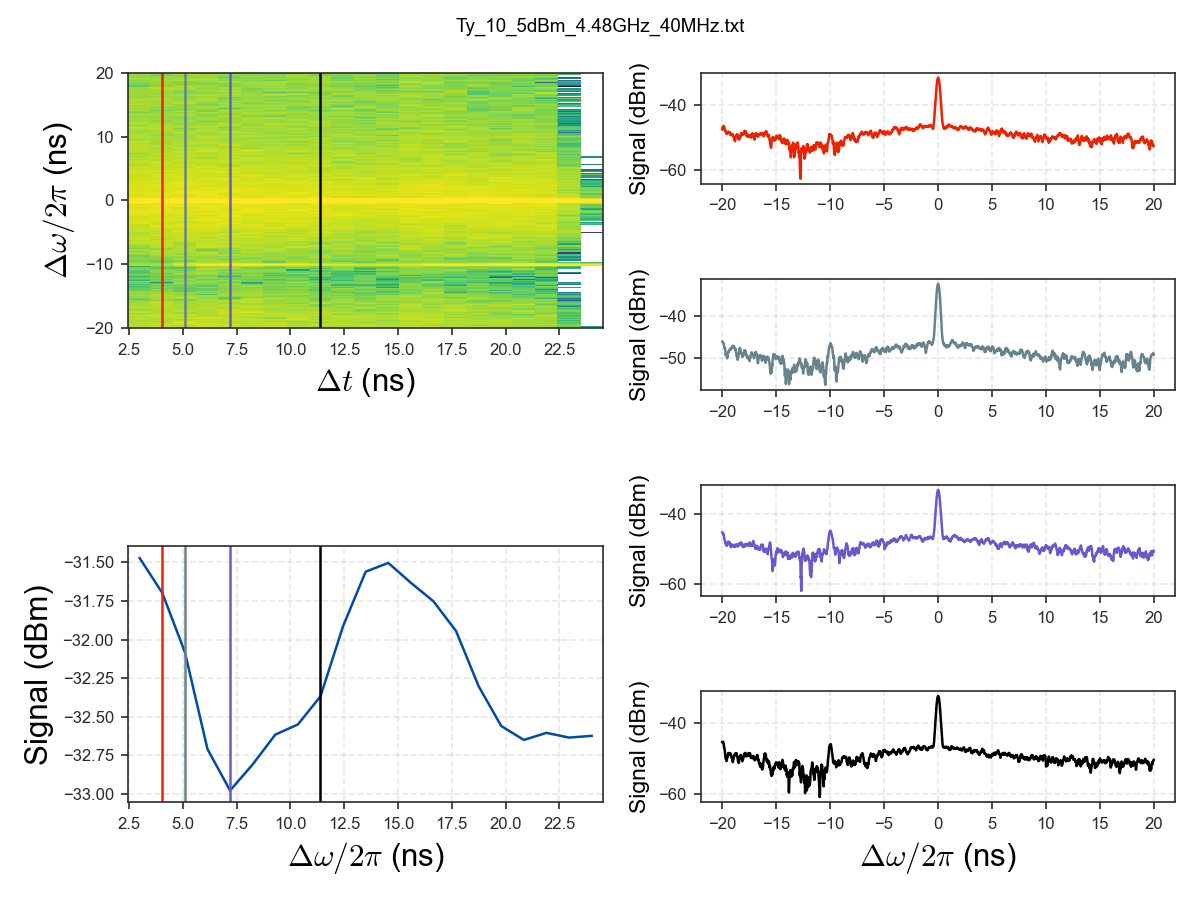

In [178]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

# Indexes where to slice
idx_list = [
    (1, MY_COLOURS["DarkRed"]),
    (2, MY_COLOURS["LightBlue"]),
    (4, MY_COLOURS["Purple"]),
    (8, "black")    
]

ax = plt.subplot(221)
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.viridis,
              vmax=-45
             )
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)

ax = plt.subplot(223, sharex=ax)
ax.plot(data3d_x, data3d_z[len(data3d_y) // 2])
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("Signal (dBm)", fontsize=15)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)

l = len(idx_list)
subplot_index = l*100 + 22 # Index magic :D
for i, (idx, col) in enumerate(idx_list):
    ax = plt.subplot(subplot_index + 2*i)
    ax.plot(data3d_y, 
            data3d_z[:,idx], 
             color=col,
#             label=f"@ {data3d_x[idx]:.2f}ns",
#             alpha=0.8+(i/l)*0.2, linewidth=l-i
           )
    ax.set_ylabel("Signal (dBm)", fontsize=11)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
plt.tight_layout()
# plt.savefig(FILENAME.replace("txt", "pdf"), dpi=100)

## Ty_12_4.48GHz_-2dBm_incoherent-search_RBW-1MHz

In [181]:
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_12_4.48GHz_-2dBm_incoherent-search_RBW-1MHz.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


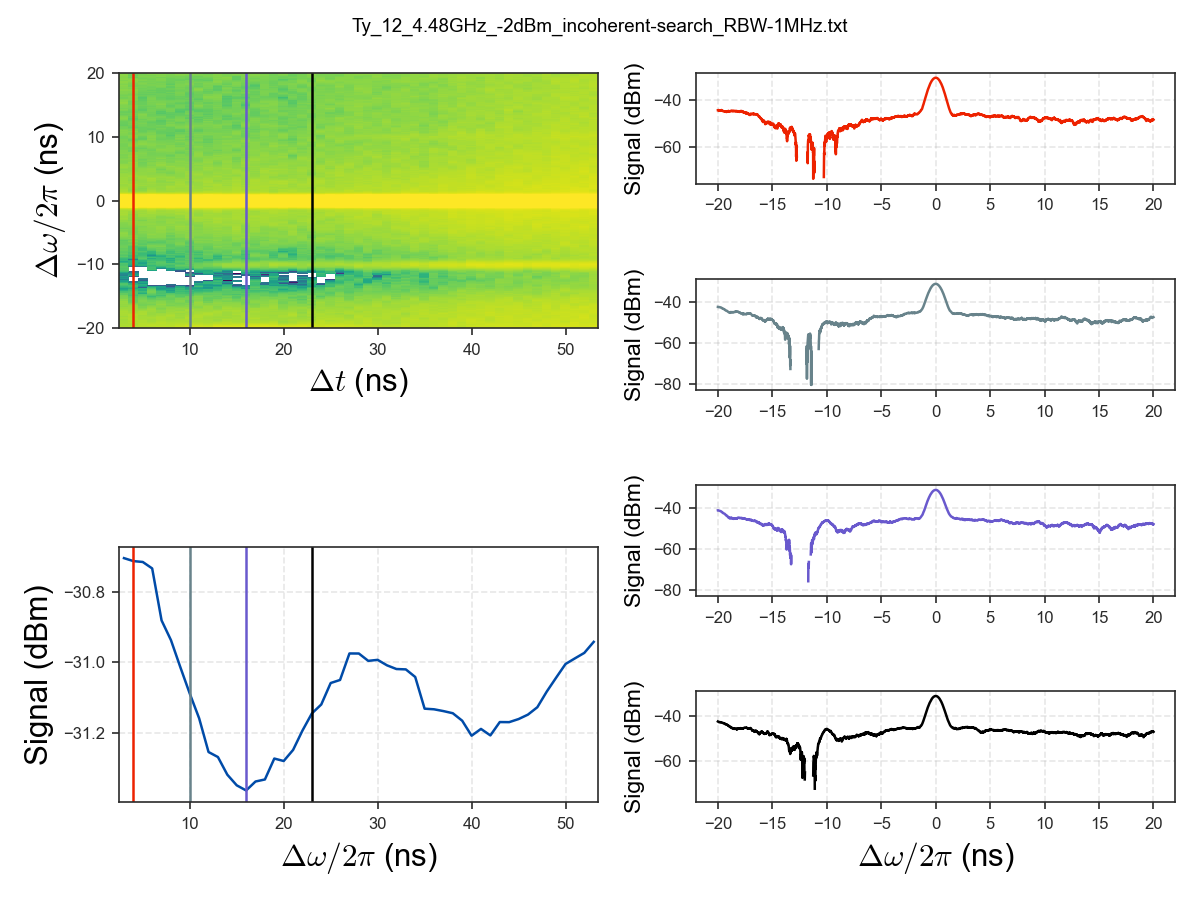

In [186]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

# Indexes where to slice
idx_list = [
    (1, MY_COLOURS["DarkRed"]),
    (7, MY_COLOURS["LightBlue"]),
    (13, MY_COLOURS["Purple"]),
    (20, "black")    
]

ax = plt.subplot(221)
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.viridis,
              vmax=-40
             )
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)

ax = plt.subplot(223, sharex=ax)
ax.plot(data3d_x, data3d_z[len(data3d_y) // 2])
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("Signal (dBm)", fontsize=15)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)

l = len(idx_list)
subplot_index = l*100 + 22 # Index magic :D
for i, (idx, col) in enumerate(idx_list):
    ax = plt.subplot(subplot_index + 2*i)
    ax.plot(data3d_y, 
            data3d_z[:,idx], 
             color=col,
#             label=f"@ {data3d_x[idx]:.2f}ns",
#             alpha=0.8+(i/l)*0.2, linewidth=l-i
           )
    ax.set_ylabel("Signal (dBm)", fontsize=11)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "pdf"), dpi=100)

## Ty_12_4.48GHz_-2dBm_incoherent-search_RBW-1MHz_all-amplifiers

In [187]:
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_12_4.48GHz_-2dBm_incoherent-search_RBW-1MHz_all-amplifiers.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


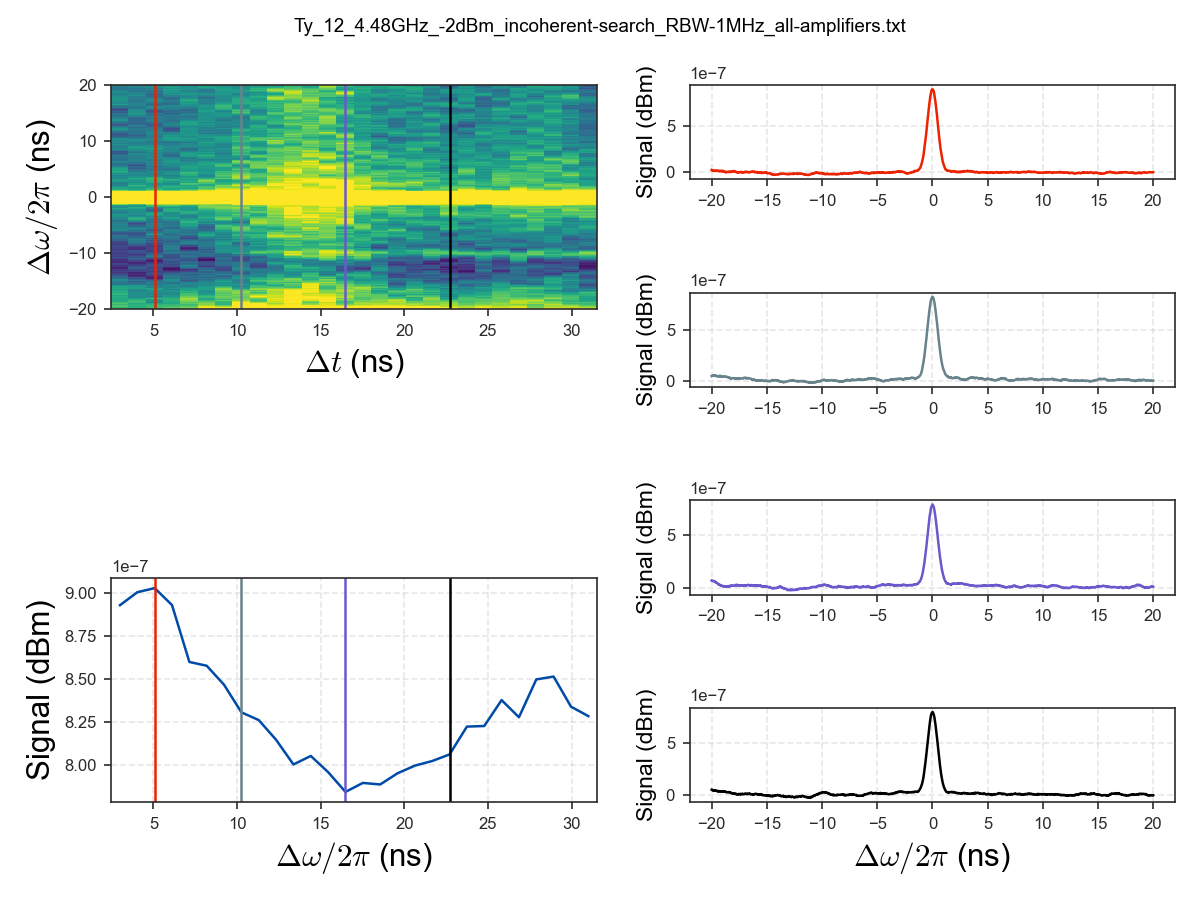

In [195]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

# Indexes where to slice
idx_list = [
    (2, MY_COLOURS["DarkRed"]),
    (7, MY_COLOURS["LightBlue"]),
    (13, MY_COLOURS["Purple"]),
    (19, "black")    
]

ax = plt.subplot(221)
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.viridis,
              vmax=0.4*10**(-7)
             )
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)

ax = plt.subplot(223, sharex=ax)
ax.plot(data3d_x, data3d_z[len(data3d_y) // 2])
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("Signal (dBm)", fontsize=15)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)

l = len(idx_list)
subplot_index = l*100 + 22 # Index magic :D
for i, (idx, col) in enumerate(idx_list):
    ax = plt.subplot(subplot_index + 2*i)
    ax.plot(data3d_y, 
            data3d_z[:,idx], 
             color=col,
#             label=f"@ {data3d_x[idx]:.2f}ns",
#             alpha=0.8+(i/l)*0.2, linewidth=l-i
           )
    ax.set_ylabel("Signal (dBm)", fontsize=11)
ax.set_xlabel("$\Delta{\omega}/2\pi$ (ns)", fontsize=15)
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "pdf"), dpi=100)